TODO: Add Title
TODO: Add TOC
TODO: Add Introduction (include kaggle link in intro) - https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data and checking it's shape

In [7]:
# Load the dataset
# This is the core dataset. From each order you might find all other information.
df_orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")

# This dataset includes data about the items purchased within each order.
df_order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")

# This dataset includes data about the orders payment options.
df_order_payments = pd.read_csv("../data/raw/olist_order_payments_dataset.csv")

# This dataset includes data about the reviews made by the customers.
# After a customer purchases the product from Olist Store a seller gets notified to fulfill that order.
# Once the customer receives the product, or the estimated delivery date is due,
# the customer gets a satisfaction survey by email where he can give a note for the purchase experience
# and write down some comments.
df_order_reviews = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")

# This dataset includes data about the products sold by Olist.
df_products = pd.read_csv("../data/raw/olist_products_dataset.csv")

# This dataset includes data about the sellers that fulfilled orders made at Olist.
# Use it to find the seller location and to identify which seller fulfilled each product.
df_sellers = pd.read_csv("../data/raw/olist_sellers_dataset.csv")

# This dataset has information Brazilian zip codes and its lat/lng coordinates.
# Use it to plot maps and find distances between sellers and customers.
df_geolocation = pd.read_csv("../data/raw/olist_geolocation_dataset.csv")

# This dataset has information about the customer and its location.
# Use it to identify unique customers in the orders dataset and to find the orders delivery location.
# At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders.
# The purpose of having a customer_unique_id on the dataset is to allow you to identify customers
# that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.
df_customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")

df_name_translation = pd.read_csv("../data/raw/product_category_name_translation.csv")

In [11]:
dfs = {"Orders": df_orders,
       "Order_items": df_order_items,
       "Order_Payments": df_order_payments,
       "Order_reviews": df_order_reviews,
       "Products": df_products,
       "Sellers": df_sellers,
       "Geolocation": df_geolocation,
       "Customers": df_customers,
       "Name_Translation": df_name_translation}

In [12]:
for key, value in dfs.items():
    print(f'The {key} dataset has {value.shape[0]} rows and {value.shape[1]} columns')

The Orders dataset has 99441 rows and 8 columns
The Order_items dataset has 112650 rows and 7 columns
The Order_Payments dataset has 103886 rows and 5 columns
The Order_reviews dataset has 99224 rows and 7 columns
The Products dataset has 32951 rows and 9 columns
The Sellers dataset has 3095 rows and 4 columns
The Geolocation dataset has 1000163 rows and 5 columns
The Customers dataset has 99441 rows and 5 columns
The Name_Translation dataset has 71 rows and 2 columns


In [139]:
def plotDistributionBar(df, columnName, top_n = 0):
    # TODO : Add documentation string
    percentages_all = round(df[columnName].value_counts(normalize=True)*100, 2)
    percentages = {}
    if top_n == 0:
        percentages = percentages_all
    else:
        if top_n < len(percentages_all) and top_n > 0:
            percentages = percentages_all[:top_n]

    plt.figure()
    if len(percentages_all) > 10:
        plt.figure(figsize=(15,5))
    graph = plt.bar(percentages.index, percentages.values)
    plt.title(f"Distribution of {columnName} in the dataset")
    plt.xticks(rotation=45)
    if len(percentages_all) > 10:
        plt.xticks(rotation=90)
    for p in graph:
        height=p.get_height()
        plt.annotate( "{}%".format(height),(p.get_x() + p.get_width()/2, height+.05),ha="center",va="bottom",fontsize=9)
    plt.show()

### 1. Orders dataset

In [32]:
df_orders.sample()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
62479,4d72fbd8a8a12d4012b8578725c97a06,97fcee340b3932c2884ef7a9305d3b05,delivered,2018-07-01 13:34:01,2018-07-01 13:49:40,2018-07-02 15:16:00,2018-07-03 21:22:32,2018-07-16


In [33]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


We can see that date  have type object, let's change it to datetime

In [34]:
df_orders['order_purchase_timestamp'] = df_orders['order_purchase_timestamp'].astype('datetime64[ns]')
df_orders['order_approved_at'] = df_orders['order_approved_at'].astype('datetime64[ns]')
df_orders['order_delivered_carrier_date'] = df_orders['order_delivered_carrier_date'].astype('datetime64[ns]')
df_orders['order_delivered_customer_date'] = df_orders['order_delivered_customer_date'].astype('datetime64[ns]')
df_orders['order_estimated_delivery_date'] = df_orders['order_estimated_delivery_date'].astype('datetime64[ns]')

In [35]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [36]:
#checking the null values
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [37]:
#checking duplicates across rows
df_orders.duplicated().sum()

0

In [38]:
#checking duplicates across columns
df_orders.columns.has_duplicates

False

In [39]:
# checking unique values for order_id
df_orders['order_id'].nunique()

99441

order_id is the primary key of this dataset  
We fixed the data type of 5 fields
There are null values in 3 fields, let's see whether this is related to order status

In [40]:
df_orders['order_status'].nunique()

8

In [41]:
df_orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

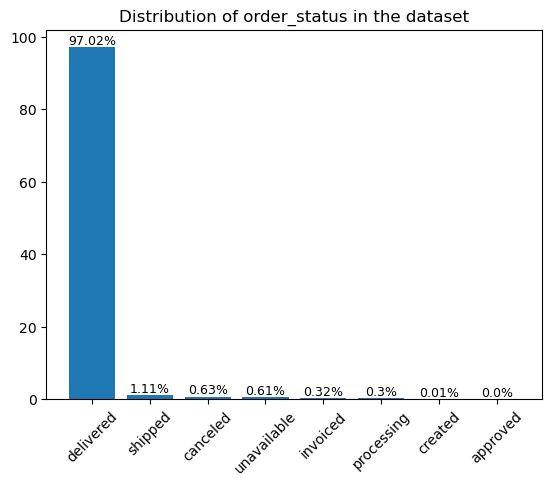

In [135]:
plotDistributionBar(df_orders,'order_status')

In [43]:
#checking the status where all the values are missing
df_orders.loc[df_orders['order_delivered_customer_date'].isnull() & \
           df_orders['order_delivered_carrier_date'].isnull() & \
           df_orders['order_approved_at'].isnull() ]['order_status'].value_counts()

order_status
canceled    141
created       5
Name: count, dtype: int64

TODO: figure out what to  do with the null values

### 2. Order items dataset

In [30]:
df_order_items.sample(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
69216,9e0d5f27a7557c8c59cb7dafa6a060e3,1,8f3a83d431c7066aabd357f3ad3590a8,96f7c797de9ca20efbe14545bed63eec,2018-04-16 22:11:01,46.20,12.79
92921,d2b4a4076a8cb3ca3b43a1ee90b4a0e2,1,2fea0f2cec6b6324a277d4a61c2ed2c6,beadbee30901a7f61d031b6b686095ad,2018-06-27 21:18:17,35.00,7.51
71375,a2cb7138f0dbd806834e29cecfa9f454,1,fe7ad3e3828f32193dfbe6359f733a8f,46dc3b2cc0980fb8ec44634e21d2718e,2018-01-10 23:11:25,159.99,27.66
70123,a000067196006b1ac2a467ba2156b22d,1,47eb2751a902abaee353276da5d084e4,6edacfd9f9074789dad6d62ba7950b9c,2018-08-29 20:45:08,61.90,9.18
103660,eb6b32a82d2459d0ce7f2089f9eba0f2,1,78efe838c04bbc568be034082200ac20,0241d4d5d36f10f80c644447315af0bd,2018-05-07 03:15:51,99.90,21.78


In [31]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Fix the data type of `shipping_limit_date`

In [44]:
df_order_items['shipping_limit_date'] = df_order_items['shipping_limit_date'].astype('datetime64[ns]')

In [45]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [46]:
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [48]:
df_order_items.duplicated().sum()

0

In [49]:
df_order_items.columns.has_duplicates

False

In [50]:
#checking the unique values in column order_id and order_item_id
df_order_items['order_id'].nunique()

98666

In [51]:
df_order_items['order_item_id'].nunique()

21

In [52]:
df_order_items['order_item_id'].value_counts()

order_item_id
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

`order_item_id` seems to be the number of items in one order

In [54]:
df_order_items.loc[(df_order_items['order_item_id'] == 21)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57


In [56]:
df_orders.loc[df_orders['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
88849,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28


In [57]:
99441 - 98666

775

The Orders dataset has 99441 unique order ids and so it is the primary key there. The  order items table has only 98666 unique values for order ids. Does this mean that 775 order ids are missing from this table? I wonder whether that is because the order status is different in the orders table. Do some more investigation here.

#### Findings

TODO : Fill this in

### 3. Order payments dataset

In [61]:
df_order_payments.sample(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80542,82ddfc248f8af440bf04024cae6bde72,1,credit_card,1,35.45
54170,116499c6f5aa0822fcfa4f8aa8b194b4,1,credit_card,1,80.21
84413,e823ca8c2818557c5f8afc10f1e2cf2d,1,credit_card,5,59.09
101882,416f576fa91c3f4b9ea65b01c99928af,1,credit_card,2,237.29
42279,f8634a6cebe582fe768ba126c4efb871,1,credit_card,7,389.82


In [64]:
df_order_payments['payment_type'].value_counts(normalize=True)*100

payment_type
credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: proportion, dtype: float64

In [65]:
df_order_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [66]:
df_order_payments.duplicated().sum()

0

In [67]:
df_order_payments.columns.has_duplicates

False

In [68]:
df_order_payments['order_id'].nunique()

99440

In [69]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


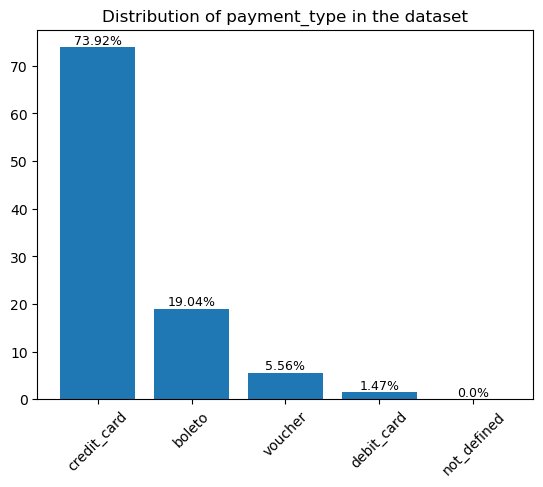

In [96]:
plotDistributionBar(df_order_payments,'payment_type')

#### Quick findings:

- Payments dataset has information about the way customer made payment for each order.
- We have payment information for 99440 unique order ids.
- This dataset has three columns of object datatype and two column with numeric datatype.
- There are no duplicates across rows or columns.
- There are no null values.
- `order_id` is the foreign key in this table.

### 4. Order reviews dataset

In [72]:
df_order_reviews.sample(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25097,54db85b14f429cf77a659733b6832deb,023b49300b34f2b9961857266df731dc,5,NaN,NaN,2017-09-29 00:00:00,2017-09-30 20:53:45
5311,c26083d821f34e4243b03a494c3ab95c,a73d54d300e639d2e14529f273fc9a1f,5,NaN,NaN,2018-05-04 00:00:00,2018-05-07 21:18:00
18689,304ac742868d90ac4b659eade3a9853d,bf9a3a8d9db6be5e4dfcfe2f071ef405,5,NaN,O produto foi entregue antes do prazo . Obriga...,2017-12-16 00:00:00,2017-12-16 23:53:48
28947,a3d3f81feab13ba44c54700da3de8731,7aaf9721911fe977bb8e6640c442aeb4,5,NaN,Parabéns pelo produto e pela rapidez da entreg...,2018-04-24 00:00:00,2018-04-25 12:42:29
96453,67ad9a335a4bdbdd81d14d4cf742d9d9,576b3b33dc81c4368f8256613418a197,5,NaN,NaN,2018-06-23 00:00:00,2018-06-26 09:44:10


In [73]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [74]:
df_order_reviews.shape

(99224, 7)

In [76]:
df_order_reviews['order_id'].nunique()

98673

- 98673 order ids have reviews
- There are multiple rows for some order ids - total rows are 99224

In [77]:
df_order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Let's fix the data type for date and timestamp

In [78]:
df_order_reviews['review_creation_date'] = df_order_reviews['review_creation_date'].astype('datetime64[ns]')
df_order_reviews['review_answer_timestamp'] = df_order_reviews['review_answer_timestamp'].astype('datetime64[ns]')

In [79]:
df_order_reviews.duplicated().sum()

0

In [80]:
df_order_reviews.columns.has_duplicates

False

In [81]:
df_order_reviews['review_score'].nunique()

5

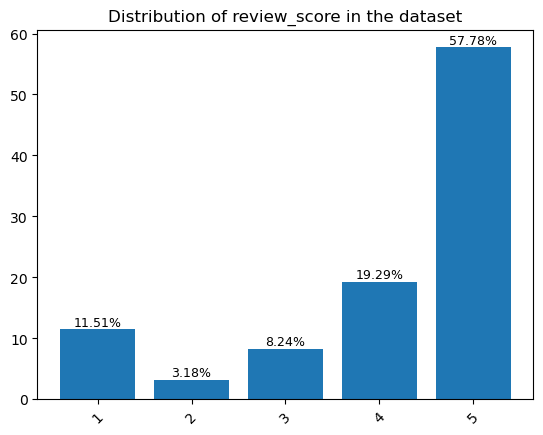

In [133]:
plotDistributionBar(df_order_reviews, 'review_score')

Since the reviews are in Portugese, we will not be using their content for any analysis.

In [97]:
df_order_reviews['review_id'].nunique()

98410

#### Quick findings


- Reviews dataset has information about reviews given by the customers. It consists of review score, comment, review creation date and review submission timestamp.
- We have a total of 99224 review ids of which 98410 are the unique review ids. It means there are 814 reviews which have been resubmitted. These are the ones that need to be tackled.
- We have 98673 unique order ids and 98410 unique review ids. It means that there are 263 reviews with same order id. It is possible that these reviews are for different products ordered under same order id.
- There are no duplicates across rows or columns.
- 57.8 % of the dataset has a review score of 5.

### 5. Products dataset

In [98]:
df_products.shape

(32951, 9)

In [99]:
df_products.sample(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
28974,c2c4abda0d688d5c2a7f48644ee55a8c,eletronicos,60.0,663.0,2.0,150.0,20.0,11.0,16.0
21814,fc5062f483f32b6e7d6e4a38c402d56c,instrumentos_musicais,51.0,437.0,1.0,10700.0,40.0,40.0,40.0
6004,368645a47a15770520ad12d9ea77c2f2,moveis_decoracao,61.0,603.0,2.0,30000.0,70.0,60.0,60.0
2850,f94d494034180bcbeb9c56cae79f6168,moveis_sala,55.0,1143.0,3.0,4650.0,31.0,17.0,31.0
1193,40c19ad8081c5efe90d93d945287adb8,perfumaria,30.0,138.0,1.0,150.0,22.0,7.0,16.0


In [100]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Let's fix the typo in the column names 'lenght' -> 'length'

In [102]:
df_products['product_name_length'] = df_products['product_name_lenght']
df_products['product_description_length'] = df_products['product_description_lenght']
df_products.drop(columns=['product_name_lenght','product_description_lenght'], inplace=True)
df_products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_photos_qty          32341 non-null  float64
 3   product_weight_g            32949 non-null  float64
 4   product_length_cm           32949 non-null  float64
 5   product_height_cm           32949 non-null  float64
 6   product_width_cm            32949 non-null  float64
 7   product_name_length         32341 non-null  float64
 8   product_description_length  32341 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [103]:
df_products['product_id'].nunique()

32951

In [115]:
df_products['product_category_name'].nunique()

73

In [112]:
df_products.isna().sum().sort_values(ascending=False)

product_category_name         610
product_photos_qty            610
product_name_length           610
product_description_length    610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
product_id                      0
dtype: int64

In [110]:
(df_products.isna().sum() / df_products.shape[0] * 100).sort_values(ascending=False)

product_category_name         1.851234
product_photos_qty            1.851234
product_name_length           1.851234
product_description_length    1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
product_id                    0.000000
dtype: float64

#### Quick findings

- Products dataset has information about product categories, and their attributes.
- `product_id` is the primary key of the dataset.
- There are 73 unique product categories.
- `product_category_name` is in Portugese
- 610 products don't have the `product_category_name`, 1.85% of the dataset
- There are few null values and we need to impute these values.

#### TODO Impute missing values for this

### 6. Sellers dataset

In [116]:
df_sellers.shape

(3095, 4)

In [117]:
df_sellers.sample(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
2277,ffff564a4f9085cd26170f4732393726,13070,campinas,SP
1056,0cab2da43793a6f3c5ed8514c5f54627,80060,curitiba,PR
2689,13074f016982ff2bd6c58ced8682f000,95705,bento goncalves,RS
3007,6ee85be3693ed79a8e80718743d80655,3937,sao paulo,SP
724,8d956fec2e4337affcb520f56fd8cbfd,9780,sao bernardo do campo,SP


In [118]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [119]:
df_sellers['seller_id'].nunique()

3095

In [120]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [121]:
df_sellers.duplicated().sum()

0

In [122]:
df_sellers.columns.has_duplicates

False

In [123]:
df_sellers['seller_state'].nunique()

23

In [124]:
df_sellers['seller_city'].nunique()

611

<Figure size 640x480 with 0 Axes>

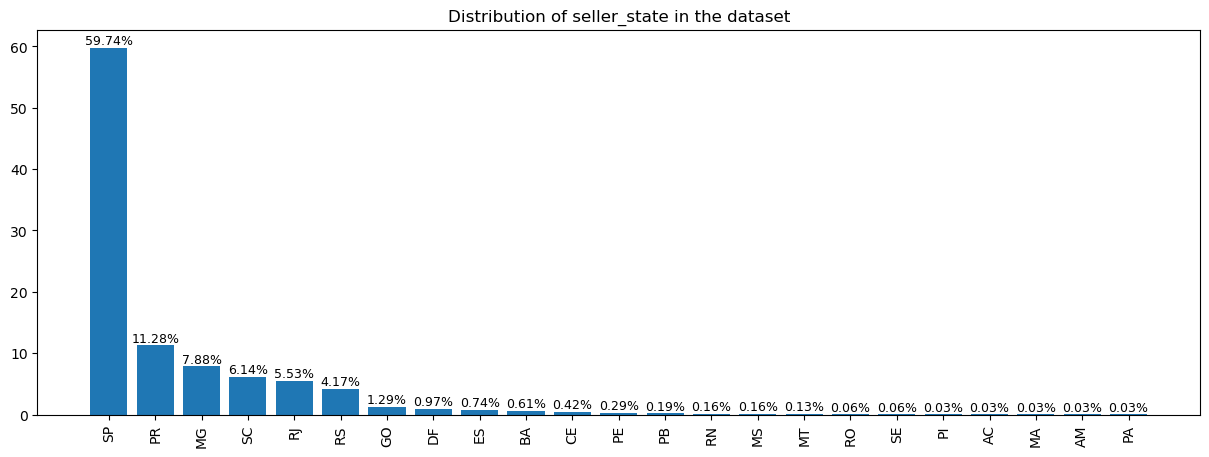

In [140]:
plotDistributionBar(df_sellers, 'seller_state')

- `seller_id` is the primary key, with 3095 unique values
- There are no null values
- There are no duplicates
- Sellers are from 23 states. Brazil has 26 states in all.
- About 60 percent of the sellers are from the south eastern state of Sao Paulo. A Google search shows that Sao Paulo is the most populous state in Brazil, accounting for about 21.8 percent of the country's population. It is also the richest state in Brazil, contributing to 33.9%  of the country's GDP.

### 7. Customers dataset

In [141]:
df_customers.shape

(99441, 5)

In [142]:
df_customers.sample(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
90420,2afda983fb05aca314929a1352960eaf,e565b42507b50ecf88a9c6c1272940c4,1516,sao paulo,SP
59807,d1fcef8497d8467278fbf8b1a4c980da,8fcf94489d63ae96b1cfc198fd6079bc,9689,sao bernardo do campo,SP
10218,3f9bf157d5b9cdd0ecabe348badbc21e,e93a61367ac4e23a645f96907cdfac70,12061,taubate,SP
85914,0adbcea65a531588e0a7c68142d54192,b5e6527dc5f242231eb0248668eb2646,96445,acegua,RS
98420,5794d665b3fcd2de695dc52681b7161c,d7d9e83592f15cd50071a2d23a646956,80030,curitiba,PR


In [143]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [144]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [145]:
df_customers.duplicated().sum()

0

In [146]:
df_customers.columns.has_duplicates

False

In [147]:
df_customers['customer_id'].nunique()

99441

In [148]:
df_customers['customer_unique_id'].nunique()

96096

In [149]:
99441 - 96096

3345

In [150]:
#percentage of repeat customers
96096/99441

0.9663619633752677

There are some repeat customers, but most are new.

In [151]:
df_customers['customer_state'].nunique()

27

<Figure size 640x480 with 0 Axes>

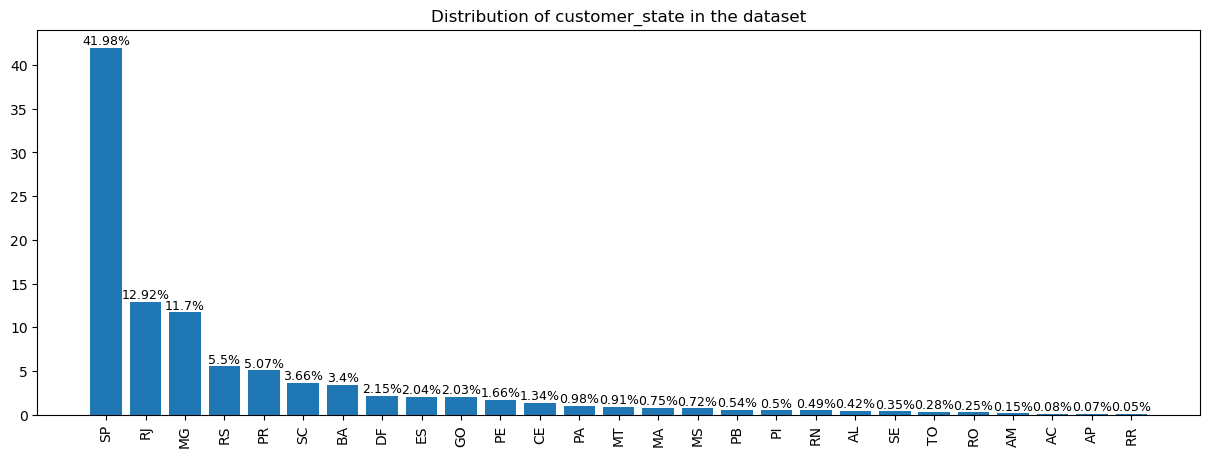

In [152]:
plotDistributionBar(df_customers, 'customer_state')

#### Quick findings

- `customer_id` is the primary key for this dataset.
- We have a total of 96096 unique customer ids. It shows that we have around 96.6 % of new customers. Only 3.4% of the customers have made repeat purchase from the olist platform. It is because olist was founded in 2015 and they started selling online in 2016. The data we downloaded from Kaggel is from 2016 to 2018, when it was fairly new thus we only have new customers.
- There are no duplicates across rows or columns.
- There is no null value.
- Sao Paulo has the largest percentage of customers.

### 8. Product category name translation dataset

In [153]:
df_name_translation.shape

(71, 2)

In [154]:
df_name_translation.sample(5)

,product_category_name,product_category_name_english
22,cool_stuff,cool_stuff
25,construcao_ferramentas_construcao,construction_tools_construction
53,pcs,computers
64,cds_dvds_musicais,cds_dvds_musicals
62,casa_conforto_2,home_comfort_2


In [155]:
df_name_translation.isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

In [156]:
df_name_translation.duplicated().sum()

0

There were 73 unique values of product_category names in the products dataset, and here we have only 71 unique values. Let's try to find out which categories are missing their english translation.

In [162]:
missing_translations = set(df_products['product_category_name']) - set(df_name_translation['product_category_name'])
missing_translations

{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [165]:
df_products.loc[df_products['product_category_name'] == 'pc_gamer'].value_counts().sum()

3

In [166]:
df_products.loc[df_products['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'].value_counts().sum()

10

Add the 2 categories with their translation to the table

In [167]:
df_name_translation.loc[len(df_name_translation.index)] = ['pc_gamer', 'pc_gamer']

In [168]:
df_name_translation.loc[len(df_name_translation.index)] = ['portateis_cozinha_e_preparadores_de_alimentos', 'portable_kitchen_gadgets']

In [169]:
df_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 0 to 72
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          73 non-null     object
 1   product_category_name_english  73 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


### 9. Geolocation dataset

In [170]:
df_geolocation.shape

(1000163, 5)

In [171]:
df_geolocation.sample(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
6098,1240,-23.544737,-46.656361,são paulo,SP
62425,3604,-23.524126,-46.550950,sao paulo,SP
173439,6704,-23.574227,-46.918311,cotia,SP
70631,3939,-23.597793,-46.501154,sao paulo,SP
849432,81150,-25.514072,-49.297281,curitiba,PR


In [172]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [173]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [174]:
df_geolocation.duplicated().sum()

261831

There are many duplicates here, we can drop that, keeping only the first of the matching row.

In [175]:
df_geolocation.drop_duplicates(keep='first', inplace=True)

In [177]:
#checking duplicates across rows
df_geolocation.duplicated().sum()

0

#### Quick findings